# Efficient Parameter Optimisation for Quantum Kernel Alignment: A Sub-sampling Approach in Variational Training

*The following tutorial has been built around the work by E. Sahin et al.* [[1]](https://arxiv.org/abs/2401.02879)

Kernel methods are a cornerstone of classical machine learning, enabling algorithms like Support Vector Machines (SVMs) to tackle nonlinear problems by mapping data into higher-dimensional spaces. Quantum kernel methods extend this concept into the quantum domain, leveraging the high-dimensional space of quantum states to capture complex patterns in data. Despite their promise, quantum kernel methods, especially quantum kernel alignment (QKA), face significant scalability issues.

The goal of QKA is to optimize the quantum kernel so that it aligns well with a given target. This target could be the labels of a supervised learning problem or another kernel that captures desired properties of the data. The alignment process involves adjusting the parameters of the quantum circuit that generates the quantum states, thereby optimizing the quantum kernel. This is done by minimizing (or maximizing) the alignment metric using techniques like gradient descent or other optimizers. The need to compute the full kernel matrix during each iteration of the training process results in substantial computational overhead, particularly as the size of the dataset increases (see Figure below, panel A).

This tutorial will focus on a novel sub-sampling approach introduced to mitigate these computational challenges. By using only a subset of the kernel matrix at each training step, this method significantly reduces the number of quantum circuits required, making it a promising technique for more scalable and efficient quantum machine learning (panel B). 

Additionally, as the focus of this tutorial is on how to implement these methods with Qiskit and Qiskit machine learning, there are tasks throughout the notebook. The answers are hinted too but not there, any time you're stuck, first check the docs linked throughout, next ask one of the presenters for help and if neither of those suits you, just go to the completed version of this notebook with all these answers filled in. Keep in mind, if you do want to code along with us, you will need to fill out the answers whether you came to them yourselves or needed them revealed, naturally the notebook needs the lines filled in to run.


![method scheme](img/schematic-view.jpg)

**Figure 1 A)** Quantum kernel alignment uses n qubits to encode the dataset into a feature map, estimate the kernel,
and optimize parameters θ until kernel separation improves. **B)** In the sub-sampling method, subsets with *k* elements of
the dataset are similarly processed using *n* qubits. This cycle repeats with different subsets, optimizing θ until the entire
dataset is sampled, yielding an optimized kernel. This will end with the estimation of the full dataset, optimised kernel.

## The method

In this step-by-step notebook, we will use the above mentioned sub-sampling approach train a quantum kernel on a labeled dataset - the Labeling Cosets with Error (LCE) dataset [[2](https://www.nature.com/articles/s41567-023-02340-9)]- for a QSVM binary classifier. 

### Quantum fidelity kernels and quantum kernel alignment

To build a quantum kernel matrix $K(x_i ,x_j)$, a quantum feature map, $\phi(x_i)$, is used to transform classical data $x_i$ into a corresponding quantum state $ |\phi(x_i)\rangle$. The Quantum Fidelity Kernel (QFK) between two classical data points, $x_i$ and $x_j$, is computed using the overlap of the related quantum states $K(x_i, x_j) = | \langle\psi ( x_i)|\psi (x_j)\rangle |^2$, where $|\psi (x_i)\rangle = U_{\phi}(x_i) |0\rangle^{\otimes n}$ and $U_{\phi}(x_i)$ is the unitary that implements the quantum feature map. The quality of such kernels can be further improved by QKA techniques. More information about QKA can be found in [[2]](https://arxiv.org/abs/2105.03406).

QKA adds a variational layer $U(\boldsymbol{\theta})$ to the kernel, where $\boldsymbol{\theta}$ are trainable parameters. The elements of the fidelity kernel matrix are computed in the same way, but now depend on $\boldsymbol{\theta}$ as shown below:

$$ K(x_i, x_j, \boldsymbol{\theta}) =  |\langle\psi (\boldsymbol{\theta}, x_i)|\psi (\boldsymbol{\theta}, x_j)\rangle |^2 $$
where $|\psi (\boldsymbol{\theta}, x_i)\rangle = U_{\phi}(x_i) U(\boldsymbol{\theta}) |0\rangle^{\otimes n} $

The training of the variational quantum kernel can be seen as finding a kernel that minimizes the upper bound of the SVM generalization error. This is equivalent to minimising a loss function $L$, expressed as

$$ L=(\boldsymbol{\theta},a) = \sum_{i} a_i - 0.5 \sum_{i,j} a_i a_j y_{i} y_{j} K(\boldsymbol{\theta},x_i, x_j) $$

where $a_i$ and $a_j$ are the optimal Lagrange multipliers, and $y$ are the labels of the binary classification problem.

### The sub-sampling approach

QKA has been shown to improve the performance of kernel methods, however it comes at a cost. For every iteration of the training process, the full kernel must be constructed which for a dataset with $m$ points requires $m^2$ inner product evaluations. Therefore, as the dataset size increases, the number of quantum circuits needed grows *quadratically*, becoming computationally and resource expensive as well as time-consuming.

In the proposed methodology, we focus on the utilization of a subset of the kernel matrix, the sub-kernel, in each step of the variational training phase until optimal parameters, $\boldsymbol{\theta}_{opt}$, are discovered. Once obtained, these parameters are used to construct the entire fidelity kernel, which is then used for QSVM training and then classification.

The workflow, represented in Figure 1.B, can be summarised as:

- *Variational parameter initialisation:* the variational parameters $\boldsymbol{\theta}$ of the quantum circuit are initialised as $\boldsymbol{\theta}_{init}$, giving an initial state $|\psi(\boldsymbol{\theta}_{init})\rangle$.
- *Variational parameters and loss function optimisation loop:* execute the optimisation loop and for each iteration, execute the following sub-steps:
    - *Dataset subsampling:* initiate by randomly selecting a distinct subset of $k$ data points from the full dataset and employ the kernel equation to construct a sub kernel, $K_{\text{sub}}$. Note that each time a new subset is selected, it is composed of previously unselected points until such a time that the entire dataset is exhausted (depending on the sub kernel and batch size), at which point previously selected points may be used again.
    - *Loss function estimation:* compute the loss function $L$ using $K_{\text{sub}}$.
    - *Loss function optimisation:* perform an optimisation step on $L$ to update the parameters $\boldsymbol{\theta}$.
- *Full kernel estimation:* utilise the optimised parameters $\boldsymbol{\theta}_{opt}$ to compute the full quantum kernel $K_f(\boldsymbol{\theta}_{opt})$.
- *Training of classifier:* implement the full kernel in an SVM model for binary classification.

This methodology can potentially decrease the computational burden associated with training on the full kernel, whilst retaining the classification accuracy as a minimum performance. 

The exact computational savings will depend on the specific distribution of data and the convergence behaviour of the training process. As such, while sub-kernel training can potentially reduce the computational burden, careful consideration must be given to the selection of sub-kernel size and the resulting impact on convergence rate.

### The notebook structure

0. Import Local, External, and Qiskit Packages
1. Prepare the dataset
2. Quantum Fidelity Kernel classification
3. Quantum Kernel Alignment
4. The Sub-Kernel Method

## 0. Import local, external, and Qiskit packages

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from timeit import default_timer as timer
from typing import Callable, Optional, Union, List, Dict, Any, Sequence
import json
from functools import partial


# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

# Qiskit Machine Learning requirements
from qiskit_machine_learning.kernels import (
    FidelityStatevectorKernel,
    TrainableKernel,
    TrainableFidelityStatevectorKernel,
)
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.utils.loss_functions import SVCLoss
from qiskit_machine_learning.algorithms.classifiers import QSVC

# Qiskit algorithms requirements, soon to be a part of qiskit_machine_learning too
from qiskit_algorithms.optimizers import SPSA, ADAM, NFT, GradientDescent, L_BFGS_B

## 1. Prepare the Dataset

We start by preparing the dataset. In this example, we load the file `dataset_graph7.csv` from the Quantum Kernel Training (QKT) Toolkit [[3]](https://github.com/qiskit-community/prototype-quantum-kernel-training/tree/main/data). This is the labeling Cosets with error dataset, which is synthetic dataset designed to evaluate quantum machine learning algorithm accuracies. More information about the structure of this particular dataset is in the QKT Toolkit [[4]](https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/docs/background/qkernels_and_data_w_group_structure.ipynb). If we inspect the dataset, we see that each sample has 14 features and the labels are binary $\pm1$.

In the original paper [1], the method subkernel method was benchmarked on the Labeling Cosets with Error and Second order Pauli-Z evolution datasets and then finally on a real life breast cancer dataset. All of which benefitted from applying the methodology.

In [127]:
def train_test_split(data_filepath, num_train=10, num_test=10, balanced=False):
    """
    Quick function used to split data into test and training samples.

    Args:
        data_filepath (str): filepath to read the data from.
        num_train (int): number of training samples.
        num_test (int): number of test samples.
        balanced (bool): whether there are an equal number of each class represented.

    Returns:
        X_train (np.ndarray): training sample features.
        y_train (np.ndarray): testing sample features.
        X_test (np.ndarray): training sample labels.
        y_test (np.ndarray): testing sample labels.
    """
    df = pd.read_csv(data_filepath, sep=",")
    train_indices = []
    test_indices = []

    if balanced:
        unique_labels = df.iloc[:, -1].unique()

        for label in unique_labels:
            label_indices = df[df.iloc[:, -1] == label].index.to_numpy()
            np.random.shuffle(label_indices)

            train_count = min(num_train, len(label_indices))
            test_count = min(num_test, len(label_indices) - train_count)

            train_indices.extend(label_indices[:train_count])
            test_indices.extend(label_indices[train_count : train_count + test_count])

    else:
        indices = np.arange(len(df))
        np.random.shuffle(indices)

        train_indices = indices[:num_train]
        test_indices = indices[num_train : num_train + num_test]

    X_train = df.iloc[train_indices, :-1].to_numpy()
    y_train = df.iloc[train_indices, -1].to_numpy()

    X_test = df.iloc[test_indices, :-1].to_numpy()
    y_test = df.iloc[test_indices, -1].to_numpy()

    return X_train, y_train, X_test, y_test


# Load the dataset and split into train and test sets
DATA_FILEPATH = "data/checherboard_paper.csv"
training_data, training_labels, test_data, test_labels = train_test_split(
    DATA_FILEPATH, num_train=50, num_test=50
)
# The proportion of train and test datapoints can be adjusted as needed.
# Doing some quick checks.
print(training_data[0])
print("training_data: ", training_data.shape)
print("training_labels: ", training_labels.shape)
print("test_data: ", test_data.shape)
print("test_labels: ", len(test_labels))

[0.90208848 0.63733345]
training_data:  (50, 2)
training_labels:  (50,)
test_data:  (49, 2)
test_labels:  49


## 2. Quantum Fidelity Kernel classification.
Here we show how to create a Quantum Kernel (QK) in Qiskit and run a classification task using Qiskit machine learning's Quantum Support Vector Classifier (`QSVC`). Before we can create a QK, we must first design our feature map.


### 2.a. The Covariant Feature Map

We create the `CovariantFeatureMap` map taken from the QKT Toolkit. This is an extension of Qiskit's [`QuantumCircuit`](ref QuantumCircuit). This feature map is tailored to the group structure of this particular dataset and is parameterised by a vector of parameters $\mathbf{\theta}$ of length equal to the number of qubits (feature dimension). For a deeper look into covariant quantum kernels for data with group structure consult the QKT Toolkit docs [[4]](https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/docs/background/qkernels_and_data_w_group_structure.ipynb). For more information on defining quantum feature maps in Qiskit, consult their guide on creating custom feature maps [[5]](https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/docs/how_tos/create_custom_quantum_feature_map.ipynb) and building trainable feature maps from existing circuits in Qiskit's circuit library [[6]](https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/docs/how_tos/train_kernels_using_qiskit_feature_maps.ipynb). 

To instantiate the `CovariantFeatureMap`, we specify:
- Feature dimension
- Entanglement structure of the quantum circuit
- Type of parametrization for the trainable parameters

In this example, we set the `feature_dimension` to that of the dataset. In addition, the `entanglement` parameter controls the structure of the fiducial state of the covariant quantum feature map [[4]](https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/docs/background/qkernels_and_data_w_group_structure.ipynb). We choose `entanglement` to match the graph used to generate the dataset (a subgraph of the heavy-hexagon lattice [[7]](https://www.ibm.com/quantum/blog/heavy-hex-lattice)). With this selection, we expect our model to perform well on this dataset. However, other entanglement structures can be used if one does not have prior knowledge of what might constitute a good choice.

In [128]:
class CovariantFeatureMap(QuantumCircuit):
    """The Covariant Feature Map circuit.

    On 3 qubits and a linear entanglement, the circuit is represented by:

    .. parsed-literal::A

         ┌──────────────┐       ░ ┌─────────────────┐┌─────────────────┐
    q_0: ┤ Ry(θ_par[0]) ├─■─────░─┤ Rz(-2*x_par[1]) ├┤ Rx(-2*x_par[0]) ├
         ├──────────────┤ │     ░ ├─────────────────┤├─────────────────┤
    q_1: ┤ Ry(θ_par[1]) ├─■──■──░─┤ Rz(-2*x_par[3]) ├┤ Rx(-2*x_par[2]) ├
         ├──────────────┤    │  ░ ├─────────────────┤├─────────────────┤
    q_2: ┤ Ry(θ_par[2]) ├────■──░─┤ Rz(-2*x_par[5]) ├┤ Rx(-2*x_par[4]) ├
         └──────────────┘       ░ └─────────────────┘└─────────────────┘

    where θ_par is a vector of trainable feature map parameters and x_par is a
    vector of data-bound feature map parameters.
    """

    def __init__(
        self,
        feature_dimension: int,
        entanglement: Union[str, List[List[int]], Callable[[int], List[int]]] = None,
        include_training_parameters: bool = True,
        name: str = "CovariantFeatureMap",
    ) -> None:
        """Create a new Covariant Feature Map circuit.

        Args:
            feature_dimension (int): The number of features.
            entanglement (str, List, Callable): Specifies the entanglement scheme.
            include_training_parameters (bool): If True, includes trainable parameters, otherwise excludes them.

        Returns:
            None
        """
        #if (feature_dimension % 2) != 0:
        #    raise ValueError(
        #        """
        #        Covariant feature map requires an even number of input features.
        #        """
        #    )
        self.feature_dimension = feature_dimension
        self.entanglement = entanglement
        self.include_training_parameters = include_training_parameters
        self.training_parameters = None
        self.input_parameters = None

        num_qubits = feature_dimension // 2
        super().__init__(num_qubits, name=name)

        self._generate_feature_map()

    @property
    def settings(self) -> Dict[str, Any]:
        training_parameters_list = [param for param in self.training_parameters]
        input_parameters_list = [param for param in self.input_parameters]
        return {
            "feature_dimension": self.feature_dimension,
            "entanglement": self.entanglement,
            "include_training_parameters": self.include_training_parameters,
            "training_parameters": training_parameters_list,
            "input_parameters": input_parameters_list,
        }

    def _generate_feature_map(self):
        # If no entanglement scheme specified, use linear entanglement
        if self.entanglement is None:
            self.entanglement = [[i, i + 1] for i in range(self.num_qubits - 1)]

        # Vector of data parameters
        input_params = ParameterVector("x_par", self.feature_dimension)

        if self.include_training_parameters:
            training_params = ParameterVector("\u03B8_par",  self.num_qubits)
            # Create an initial rotation layer of trainable parameters
            for i in range(self.num_qubits):
                self.ry(training_params[i], self.qubits[i])
            self.training_parameters = training_params
        else:
            self.training_parameters = []

        self.input_parameters = input_params

        # Create the entanglement layer
        for source, target in self.entanglement:
            self.cz(self.qubits[source], self.qubits[target])

        self.barrier()
        # Create a circuit representation of the data group
        for i in range(self.num_qubits):
            self.rz(-2 * input_params[2 * i + 1], self.qubits[i])
            self.rx(-2 * input_params[2 * i], self.qubits[i])

### Task 1.
Have a crack at utilising the CovariantFeatureMap class. 
1. Create a version with trainable parameters (fm_n) and without trainable parameters (fm).
2. Try printing out the circuit using fm.draw("mpl"). 
3. Extension - try to print out the training parameters only of the fm_n circuit, this will be important later. Checkout the `QuantumCircuit` docs for help.

We're starting small but don't be afraid to ask for assistance, we know some people here may be completely new to Qiskit even if they are adept in other QC compatible languages.

training parameters :  ['θ_par[0]']


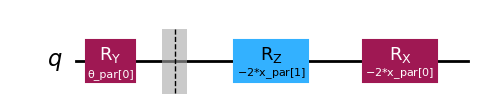

In [129]:
num_features = np.shape(training_data)[1]
#entangler_map = [[0, 2], [3, 4], [2, 5], [1, 4], [2, 3], [4, 6]]

# Creating the feature map without trainable params
# we will use this for an initial QSVC
fm_n = CovariantFeatureMap(
    feature_dimension=num_features,
    #entanglement=entangler_map,
    include_training_parameters=False,
)
# With trainable params
fm = CovariantFeatureMap(
    feature_dimension=num_features,
    #entanglement=entangler_map,
    include_training_parameters=True,
)

print("training parameters : ", [x.name for x in fm.training_parameters])
fm.draw("mpl")

### 2.b. Performing a classiciation task using a QSVC.

As mentioned previously, to utilise a kernel, classical or quantum we need to perform a classication algorithm on it. Here, we get our first taste of what the Qiskit machine learning package can do - we can perform a `QSVC` using a built in [`QSVC`](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.algorithms.QSVC.html) feature, which is an extension of sklearns SVC. The `QSVC` is initialised with a QK and when the fit method is called, it calls the QK to evaluate itself and then passes the resultant kernel to the SVC fit method.

We create a `run_QSVC` function to create and fit our `QSVC` as well as calculate some popular machine learning metrics (ROC AUC, F1, Test accuracy) to evaluate training success.

### Task 2.
1. Create a `QSVC` object (make sure to add the `proability = True` attribute so we can calculate probability outputs)
2. Run the fit method on the `QSVC`.

Consult the docs for `QSVC` for help on creating these lines or simply ask one of us.

In [130]:
def run_QSVC(training_input, train_labels, test_input, test_labels, quantum_kernel):
    """A function to fit and score a quantum support vector classifier.

    Args:
        training_input (np.ndarray): training sample features.
        train_labels (np.ndarray): training sample labels.
        test_input (np.ndarray): testing sample features.
        test_labels (np.ndarray): testing sample labels.

    Returns:
        qsvc (QSVC): the fitted qsvc object.
        auc (float): the ROC AUC score.
        f1 (float): the f1 score.
    """
    # Create the QSVC
    qsvc = QSVC(quantum_kernel=quantum_kernel, probability=True)

    # Evaluate the kernel and fit the SVC
    qsvc.fit(training_input, train_labels)

    # predict probabilities
    predicted = qsvc.predict(test_input)
    predicted_proba = qsvc.predict_proba(test_input)
    # Calculate F1-Score and write
    f1 = f1_score(test_labels, predicted, average="weighted")
    # calculate scores
    try:
        auc = roc_auc_score(test_labels, predicted_proba, multi_class="ovo", average="weighted")
    except:
        auc = roc_auc_score(test_labels, predicted_proba[:, 1])

    acc_score = accuracy_score(test_labels, predicted)
    # summarize scores
    return qsvc, auc, f1, acc_score

Now to run our first experiment. Before running the `QSVC` we must first create our QK, we will utilise Qiskit machine learning's [`FidelityStatevectorKernel`](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.kernels.FidelityStatevectorKernel.html#fidelitystatevectorkernel), this is an implementation of the `BaseKernel` which is optimised for simulated statevectors. `FidelityStatevectorKernel` is initialised with a feature map and implements a quantum kernel based on the state fidelity. As a reminder, the kernel between two classical inputs $x_i$ and $x_j$ is given by $| \langle \phi(x_i) | \phi(x_j) \rangle |^2$, where $| \phi(x_i) \rangle$ and $| \phi(x_j) \rangle$ are quantum states obtained by applying a feature map to the inputs. In this case, we use the Covariant feature map.

### Task 3
1. Create a variable `fidelity_kernel` and initialise it as a `FidelityStatevectorKernel` object with the covariant feature map with __no trainable parameters__ (fm_n).
2. Run the `run_QSVC` function to show a `QSVC` in Qiskit machine learning.
3. Extension - look at the `FidelityStatevectorKernel` docs and see if you can evaluate the kernel on the `training_data` and uncomment the plotting lines to visualise its output.

The results of the `QSVC` will indicate a poorly trained model, with all metrics showing weak results. Additionally the kernel sees little difference between fidelity for a majority of the dataset, this in part leads to the poor performance.

Evaluating Quantum Fidelity kernel...
QSVC Training Runtime: 0.1413835650000692 secs
Quantum Fidelity Kernel F1 Score = 0.392
Quantum Fidelity Kernel ROC AUC = 0.500
Quantum Fidelity Kernel Accuracy Score = 0.551



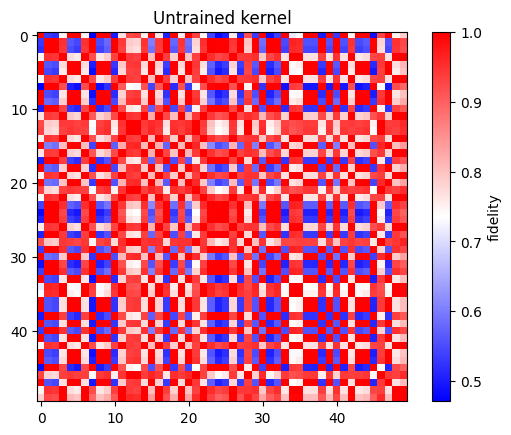

In [131]:
fidelity_kernel = FidelityStatevectorKernel(feature_map=fm_n)
print("Evaluating Quantum Fidelity kernel...")
# Evaluate the quantum fidelity kernel
start = timer()
qsvc, auc, f1, accuracy = run_QSVC(
    training_data, training_labels, test_data, test_labels, fidelity_kernel
)
end = timer()
qsvc_runtime = end - start
print(f"QSVC Training Runtime: {qsvc_runtime} secs")
# Print results
print("Quantum Fidelity Kernel F1 Score = %.3f" % (f1))
print("Quantum Fidelity Kernel ROC AUC = %.3f" % (auc))
print("Quantum Fidelity Kernel Accuracy Score = %.3f" % (accuracy))
print()

# Visualising the untrained kernel
untrained_kernel_eval = fidelity_kernel.evaluate(x_vec=training_data)
plt.imshow(untrained_kernel_eval, cmap=matplotlib.colormaps["bwr"])
plt.colorbar(label="fidelity")
plt.title("Untrained kernel")
plt.show()

## 3. Quantum Kernel Alignment

Considering the poor performance of the `QSVC`, we now look at find a way of improving the kernel, this is where Quantum Kernel Alignment (QKA) comes in. By adding training parameters to the feature map, the kernel can be optimised for the dataset. QKA aims to maximize the intra-class overlap and minimize the inter-class overlap [[2]](https://arxiv.org/pdf/2105.03406) whilst giving an upper bound on the generalisation error, allowing the SVC to generalise well and not overfit [[8]](https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/docs/background/svm_weighted_kernel_alignment.ipynb).

### 3.a. Loss and Callback

To fit the kernel we need a metric for knowing how well the current parameters $\boldsymbol\theta$ are performing. Here we use Qiskit machine learning's [`SVCLoss`](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.utils.loss_functions.SVCLoss.html). Given training samples, $x_{i}$, with binary labels, $y_{i}$ and a parameterised kernel, $K(\boldsymbol\theta,x_i, x_j)$ parameterized by values, $\boldsymbol\theta$, the loss is defined as:
    
$$ \text{SVCLoss} = \sum_{i} a_i - 0.5 \sum_{i,j} a_i a_j y_{i} y_{j} K(\boldsymbol\theta,x_i, x_j) $$

where $a_i$ are the optimal Lagrange multipliers found by solving the standard SVM quadratic program. Note that the hyper-parameter `C` for the soft-margin penalty can be specified through the keyword args.

Minimizing this loss over the parameters, $\boldsymbol\theta$, of the kernel is equivalent to maximizing a weighted kernel alignment, which in turn yields the smallest upper bound to the SVM generalization error for a given parameterization. See [[2](https://arxiv.org/abs/2105.03406)] for further details.

Before performing the QKA, we need to define our optimisers and callback function. Callback functions are a feature of Qiskit machine learning and are used to provide feedback during the optimisation process. The `QKTCallback` class below is an implementation of this.

In [132]:
class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        """Initialise the class with a data array."""
        self._data = [[] for i in range(5)]

    def callback(
        self,
        n_func_iter,
        weights=None,
        func_value=None,
        step_size=None,
        step_accepted=None,
    ):
        """
        Args
            n_func_iter (int): number of function evaluations.
            weights (np.ndarray): the current weights.
            func_value (float): the function value.
            step_size (float): the step size.
            step_accepted (bool): whether the step was accepted.

        Returns:
            None
        """
        self._data[0].append(n_func_iter)
        self._data[1].append(weights)
        self._data[2].append(func_value)
        self._data[3].append(step_size)
        self._data[4].append(step_accepted)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

### 3.b. Optimizer Helper Function
Now we need something to do the hard work: an optimiser. These optimisers originate from qiskit_algorithms but recently joined the Qiskit machine learning library. To optimize the parameters of our quantum circuit, we mostly use gradient-based optimization methods. There are several optimization methods to choose from, and the choice of the optimizer can significantly influence the speed of convergence and the quality of the final solution. For this notebook we will focus on the `SPSA` optimiser, though feel free to try some others later on.

The get_optimizer_options function presented below allows us to flexibly choose from various optimization methods available in the Qiskit SDK [[9]](https://qiskit-community.github.io/qiskit-algorithms/apidocs/qiskit_algorithms.optimizers.html) and returns the chosen optimizer function using partial to pass some optimised parameters found. We provide support for the following optimizers:

* [Simultaneous Perturbation Stochastic Approximation](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html#qiskit.algorithms.optimizers.SPSA) (SPSA): SPSA is an gradient descent method for optimizing systems with multiple unknown parameters. As an optimization method, it is appropriately suited to large-scale population models, adaptive modeling, and simulation optimization.

* [Adaptive Moment Estimation](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.ADAM.html#qiskit.algorithms.optimizers.ADAM) (ADAM): ADAM is an extension of stochastic gradient descent and is one of the default optimizers in many deep learning libraries. It is a gradient-based optimization algorithm that is relies on adaptive estimates of lower-order moments. The algorithm requires little memory and is invariant to diagonal rescaling of the gradients. Furthermore, it is able to cope with non-stationary objective functions and noisy and/or sparse gradients.

* [Gradient Descent](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.GradientDescent.html#qiskit.algorithms.optimizers.GradientDescent) (GD): GD is a first-order iterative optimization algorithm for finding a local minimum of a differentiable function. It works by taking steps proportional to the negative of the gradient at the current point. 

* [Nakanishi-Fujii-Todo](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.NFT.html#qiskit.algorithms.optimizers.NFT) algorithm (NFT): The NFT is a sequential minimal optimization method for quantum-classical hybrid algorithms, which converges faster, is robust against statistical error, and is hyperparameter-free [[10]](https://arxiv.org/abs/1903.12166).

* [Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS-B)](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.L_BFGS_B.html#qiskit.algorithms.optimizers.L_BFGS_B): The L-BFGS-B is an algorithm for solving nonlinear optimization problems. It is a member of the broad class of quasi-Newton optimization methods. L-BFGS-B uses a limited amount of computer memory to approximate the inverse Hessian matrix.

In [133]:
def get_optimizer_options(optimizer_type):
    if optimizer_type == "SPSA":
        optimizer = partial(SPSA, maxiter=300, learning_rate=0.002, perturbation=0.05)
        callback = "SPSACallback"
    elif optimizer_type == "ADAM":
        optimizer = partial(ADAM, maxiter=600, tol=1e-08, lr=0.002)
        callback = None
    elif optimizer_type == "GradientDescent":
        optimizer = partial(
            GradientDescent,
            maxiter=400,
            learning_rate=0.002,
            tol=1e-08,
            perturbation=None,
        )
        callback = "SPSACallback"
    elif optimizer_type == "NFT":
        optimizer = partial(NFT, disp=False)
        callback = None
    elif optimizer_type == "L_BFGS_B":
        optimizer = partial(
            L_BFGS_B,
            maxfun=15000,
            maxiter=15000,
            ftol=2.220446049250313e-15,
            iprint=-1,
            eps=1e-08,
        )
        callback = None
    return callback, optimizer

### 3.c. Experiment and Visualisation

To train the quantum kernel on the dataset (samples and labels), we use the Qiskit machine learning [`QuantumKernelTrainer`](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.kernels.algorithms.QuantumKernelTrainer.html#qiskit_machine_learning.kernels.algorithms.QuantumKernelTrainer) (QKT). This will take in a `TrainableKernel` object which is contains trainable kernel parameters, we use [`TrainableFidelityStatevectorKernel`](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.kernels.TrainableFidelityStatevectorKernel.html#qiskit_machine_learning.kernels.TrainableFidelityStatevectorKernel), a trainable version of `FidelityStatevectorKernel`. The QKT also needs a loss function, we pass "svc_loss" to use the `SVCLoss` previously described. The QKA is performed by optimising the variational parameters using the `.fit` method.

The output of `QuantumKernelTrainer.fit` is a [`QuantumKernelTrainerResult`](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.kernels.algorithms.QuantumKernelTrainerResult.html#qiskit_machine_learning.kernels.algorithms.QuantumKernelTrainerResult) object. The results object contains the following class fields:
 - `optimal_parameters`: A dictionary containing {parameter: optimal value} pairs
 - `optimal_point`: The optimal parameter value found in training
 - `optimal_value`: The value of the loss function at the optimal point
 - `optimizer_evals`: The number of evaluations performed by the optimizer
 - `optimizer_time`: The amount of time taken to perform optimization
 - `quantum_kernel`: A `TrainableKernel` object with optimal values bound to the feature map

 ### Task 4.
 1. Initialise a `TrainableFidelityStatevectorKernel` quantum kernel. This time you will need to use the feature map that includes the trainable parameters and you will need to specify those parameters.
 2. Initilaise a `QuantumKernelTrainer` object using your quantum kernel. Here you'll need to specify the loss, optimizer and initial point for reproducable results.
 3. Fit the `QuantumKernelTrainer` using the `.fit` method.

 Training Runtime: 29.13572895499965 secs. Results: 
--------------------------------------------------------------------------------



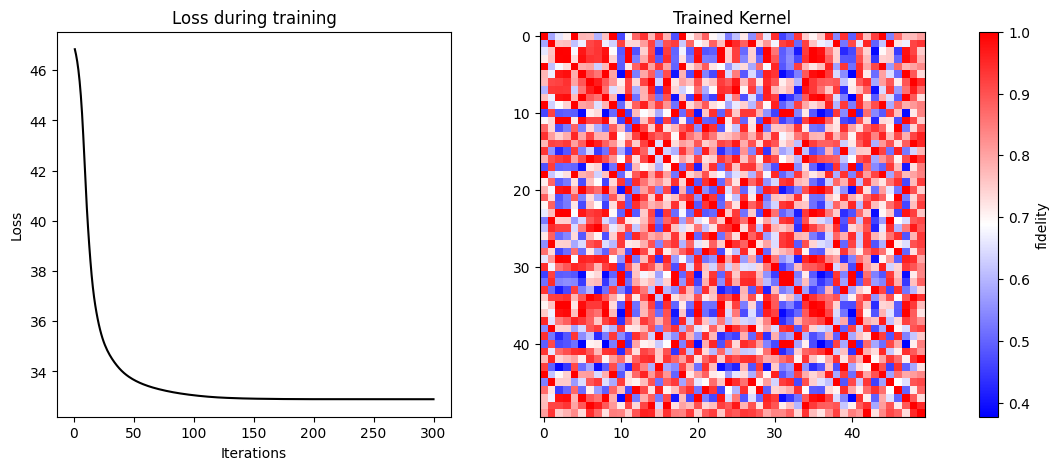

In [134]:
# Instantiate quantum kernel
quant_kernel = TrainableFidelityStatevectorKernel(
    feature_map=fm, training_parameters=fm.training_parameters
)

# Set up the optimizer
optimizer = "SPSA"
cb, optimizer = get_optimizer_options(optimizer)
if cb == "SPSACallback":
    callb = QKTCallback()
    optimizer = optimizer(callback=callb.callback)
else:
    optimizer = optimizer()

init_p = 0.25 * np.random.uniform(-np.pi, np.pi, len(fm.training_parameters))
# Instantiate a quantum kernel trainer.
qkt = QuantumKernelTrainer(
    quantum_kernel=quant_kernel, loss="svc_loss", optimizer=optimizer, initial_point=init_p
)
# Train the kernel
start = timer()
qka_results = qkt.fit(training_data, training_labels)
end = timer()
train_time = end - start
print(f" Training Runtime: {train_time} secs. Results: ")
print("-" * 80)
print()
# print(qka_results)

# Evaulating the optimised kernel on the training data
trained_kernel_eval = qka_results.quantum_kernel.evaluate(training_data)

# Graphing
if callb is not None:
    plot_data = callb.get_callback_data()  # callback data
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="")
    ax[0].set_xlabel("Iterations")
    ax[0].set_ylabel("Loss")
    ax[0].set_title("Loss during training")
    im = ax[1].imshow(trained_kernel_eval, cmap=matplotlib.colormaps["bwr"])
    ax[1].set_title("Trained Kernel")
    fig.colorbar(im, ax=ax, label="fidelity")
    plt.show()
else:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax[0].imshow(trained_kernel_eval, cmap=matplotlib.colormaps["bwr"])
    plt.show()

We can see the above loss graph shows us the loss has converged and the outputted trained kernel has much more contrast than our untrained kernel. This is the action of increasing intra-class fidelities and decreasing inter-class fidelities. We can next run a `QSVC` to see the increase in performance when using the Aligned QK.

In [135]:
# Evaluate the quantum fidelity kernel
start = timer()
qsvc, auc, f1, accuracy = run_QSVC(
    training_data, training_labels, test_data, test_labels, qka_results.quantum_kernel)
end = timer()
qsvc_runtime = end - start
print(f"QSVC Training Runtime: {qsvc_runtime} secs")
# Print results
print("Quantum Fidelity Kernel F1 Score = %.3f" % (f1))
print("Quantum Fidelity Kernel ROC AUC = %.3f" % (auc))
print("Quantum Fidelity Kernel Accuracy Score = %.3f" % (accuracy))
print(
    "Increase in overall time by aligning kernel = %.3f"
    % ((train_time + qsvc_runtime) * 100 / qsvc_runtime),
    "%",
)

QSVC Training Runtime: 0.14174410499981605 secs
Quantum Fidelity Kernel F1 Score = 0.550
Quantum Fidelity Kernel ROC AUC = 0.811
Quantum Fidelity Kernel Accuracy Score = 0.551
Increase in overall time by aligning kernel = 20655.161 %


The `QSVC` metrics are stellar across the board and the aligned QK is much successful at the classification problem. However, aligning the kernel increases runtime by a signficant margin, this increase is exactly correlated to the number of optimiser iterations. This is a steep cost for the increase in performance as the kernel calculation is already _quadratic_ with number of features and this must be done at each iteration step. Additionally, there are are other considerations with QKs like shot noise, higher error rates and the need for error mitigation or correction. This neatly brings us to the sub-kernel method, a way of reducing computational burden.

## 4. The Sub-Kernel Method
### 4.a. How to Implement

The sub-kernel methodology is an adaptation of the QFK method which uses sub-portions of the dataset to calculate a sub-kernel. The core idea behind the sub-kernel methodology is to randomly select a subset of the data points, referred to as a "sub-kernel", on each step of the training process until optimal parameters are found. 

In mathematical terms, , we calculate the kernel function only for the points in $\mathcal{D'}$ in each iteration.

Formally, if $\mathcal{D}$ is our dataset and $\mathcal{D'}$ is a randomly sampled subset of $\mathcal{D}$ for each iteration $i$, we sample a subset $\mathcal{D}_i' \subset \mathcal{D}$ of size $k \ll m$, where $m$ is the size of the full dataset. Then we compute the fidelity kernel $\mathbf{K}_{\mathcal{D}_i'}$ on the subset $\mathcal{D}_i'$ and update the parameters of our variational parameteres accordingly. This process continues iteratively until given conditions met. 

This method aims at reducing the computational cost of kernel construction. Despite this reduction, it preserves the essential features of the data, and thus, maintains good classification performance.

To realise the sub-kernel method in Qiskit, we must create two additional classes. The first is the `DataBatcher` class, used to generate a list of balanced batches, where each batch contains the same number of samples from each label or a list of imbalanced batches, where each batch may contain a different number of samples from each label with given options. This function creates set of $\mathcal{D'}$ from $\mathcal{D}$.

In [136]:
class DataBatcher:
    """
    A class used to batch dataset and labels.
    """

    def __init__(self, dataset, labels):
        """
        Initialize a DataBatches object with the input dataset and corresponding labels.

        Args:
            dataset (numpy array): A numpy array of shape (num_samples, num_features) containing the input dataset.
            labels (numpy array): A numpy array of shape (num_samples,) containing the corresponding labels for the dataset.

        Returns:
            None
        """
        self.dataset = dataset
        self.labels = labels
        self.num_samples = len(dataset)
        self.unique_labels, self.label_counts = np.unique(labels, return_counts=True)

    def balanced_batches(self, batch_size, shuffle=False):
        """
        Generate a list of balanced batches, where each batch contains the same number of samples from each label.

        Args:
            batch_size (int): The desired size of each batch.
            shuffle (bool): if True, shuffle batches.

        Returns:
            batches (List): a list of batches where each batch is a tuple containing the batch data and corresponding labels.
        """
        if batch_size > self.num_samples:
            raise ValueError(
                f"Batch size {batch_size} is larger than the dataset size {self.num_samples}"
            )
        if batch_size > 2 * np.min(self.label_counts):
            raise ValueError(
                f"Batch size {batch_size} is 2x larger than the smallest label size {np.min(self.label_counts)}"
            )
        samples_per_label = batch_size // len(self.unique_labels)
        batches = []
        for _ in range(self.num_samples // batch_size):
            batch_data = []
            batch_labels = []
            for l in self.unique_labels:
                label_indices = np.where(self.labels == l)[0]
                if shuffle:
                    np.random.shuffle(label_indices)
                if samples_per_label > len(label_indices):
                    batch_indices = label_indices
                else:
                    batch_indices = label_indices[:samples_per_label]
                batch_data.append(self.dataset[batch_indices])
                batch_labels.append(self.labels[batch_indices])
            batch_data = np.concatenate(batch_data, axis=0)
            batch_labels = np.concatenate(batch_labels, axis=0)
            batches.append((batch_data, batch_labels))
        return batches

    def imbalanced_batches(self, batch_size, keep_ratio=False, shuffle=False):
        """
        Generate a list of imbalanced batches, where each batch may contain a different number of samples from each label.

        Args:
            batch_size (int): The desired size of each batch.
            keep_ratio (bool): If True, maintain the same relative frequency of each label as in the original dataset.
                            If False, use the absolute frequency of each label to determine the number of samples per label.
            shuffle (bool): If True, shuffle batches.

        Returns:
            batches (list): a list of batches where each batch is a tuple containing the batch data and corresponding labels.
        """
        if batch_size > self.num_samples:
            raise ValueError(
                f"Batch size {batch_size} is larger than the dataset size {self.num_samples}"
            )
        if keep_ratio:
            # calculate the number of samples per label based on the relative label frequencies
            label_freqs = self.label_counts / np.sum(self.label_counts)
            samples_per_label = np.round(batch_size * label_freqs).astype(int)
        else:
            # calculate the number of samples per label based on the absolute label frequencies
            samples_per_label = np.round(
                batch_size * self.label_counts / np.sum(self.label_counts)
            ).astype(int)
        batches = []
        for _ in range(self.num_samples // batch_size):
            batch_data = []
            batch_labels = []
            for l, num_samples in zip(self.unique_labels, samples_per_label):
                label_indices = np.where(self.labels == l)[0]
                if shuffle:
                    np.random.shuffle(label_indices)
                batch_indices = label_indices[:num_samples]
                batch_data.append(self.dataset[batch_indices])
                batch_labels.append(self.labels[batch_indices])
            batch_data = np.concatenate(batch_data, axis=0)
            batch_labels = np.concatenate(batch_labels, axis=0)
            batches.append((batch_data, batch_labels))
        return batches

The second is the `BatchedSVCLoss` class. This is an extension of Qiskit machine learning `SVCLoss` and provides a kernel loss function for multiple batches of the sub-kernels. It calculates and updates the loss based of each of these classification tasks by fitting an SVC model from scikit-learn. 


In [137]:
class BatchedSVCLoss(SVCLoss):
    r"""
    This class provides a kernel loss function for classification tasks by fitting an ``SVC`` model
    from scikit-learn, extended for use with batches. Given training samples, :math:`x_{i}`, with binary labels, :math:`y_{i}`,
    and a kernel, :math:`K_{θ}`, parameterized by values, :math:`θ`, the loss is defined as:

    .. math::

        SVCLoss = \sum_{i} a_i - 0.5 \sum_{i,j} a_i a_j y_{i} y_{j} K_θ(x_i, x_j)

    where :math:`a_i` are the optimal Lagrange multipliers found by solving the standard SVM
    quadratic program. Note that the hyper-parameter ``C`` for the soft-margin penalty can be
    specified through the keyword args.

    Minimizing this loss over the parameters, :math:`θ`, of the kernel is equivalent to maximizing a
    weighted kernel alignment, which in turn yields the smallest upper bound to the SVM
    generalization error for a given parameterization.

    See https://arxiv.org/abs/2105.03406 for further details.
    """

    def __init__(
        self,
        data: np.ndarray,
        labels: np.ndarray,
        sub_kernel_size: Optional[int] = None,
        minibatch_size: Optional[int] = 1,
        shuffle: bool = False,
        balanced_batch: bool = False,
        keep_ratio: bool = True,
        encoder=None,
        **kwargs,
    ):
        """
        Args:
            data (np.ndarray): The data to evaluate the loss on.
            labels (np.ndarray): The corresponding labels for the data.
            sub_kernel_size (int, optional): The size of the sub-kernel batches to split the data into. If not provided,
                the entire data set is used in a single batch.
            shuffle (bool, optional): Whether to shuffle the data before splitting into batches. Default is False.
            balanced_batch (bool, optional): Whether to use balanced or imbalanced batching. Default is False.
            encoder (torch.nn): An instance to optionally reduce dimension before calculating loss
            **kwargs: Arbitrary keyword arguments to pass to SVC constructor within
                      SVCLoss evaluation.
        """
        super().__init__(**kwargs)
        # Split data into batches
        self.sub_kernel_size = sub_kernel_size
        bg = DataBatcher(data, labels)
        self.minibatch_size = minibatch_size
        if self.sub_kernel_size == None:
            self.batches = [data, labels]
        elif balanced_batch:
            self.batches = bg.balanced_batches(sub_kernel_size, shuffle=shuffle)
        else:
            self.batches = bg.imbalanced_batches(
                sub_kernel_size, keep_ratio=keep_ratio, shuffle=shuffle
            )

        self.idx = 0
        self.epoch = 0
        self.encoder = encoder
        self.loss_arr = []

    def evaluate(
        self,
        parameters: Sequence[float],
        quantum_kernel: TrainableKernel,
        data: np.ndarray,
        labels: np.ndarray,
    ) -> float:
        """
        Wrapper function for loss evaluation with batches of data. If sub_kernel_size is None, it will execute SVCLoss() on full dataset.

        Args:
            parameter_values (Sequence[float]): The parameter values to evaluate the loss with.
            quantum_kernel (TrainableKernel): The quantum kernel to use for evaluation.
        Returns:
            loss (float): the loss value for the given parameters and quantum kernel.
        """
        if self.sub_kernel_size == None:
            if type(self.encoder) != type(None):
                weights = parameters[: self.encoder.num_weights]
                variational_params = parameters[self.encoder.num_weights :]
                self.encoder.set_weights(weights)
                encoded_data = self.encoder.encode(data)
                return super().evaluate(variational_params, quantum_kernel, encoded_data, labels)
            else:
                loss = super().evaluate(parameters, quantum_kernel, data, labels)
                self.loss_arr.append(loss)
                return loss

        if self.idx + self.minibatch_size > len(self.batches):
            self.idx = 0
            self.epoch += 1

        mini_batch = self.batches[self.idx : self.idx + self.minibatch_size]
        # Evaluate the loss for each batch and accumulate the total loss
        total_loss = 0
        i = self.idx
        for batch_data, batch_labels in mini_batch:
            if type(self.encoder) != type(None):
                weights = parameters[: self.encoder.num_weights]
                variational_params = parameters[self.encoder.num_weights :]
                self.encoder.set_weights(weights)
                batch_data = self.encoder.encode(batch_data)
            else:
                variational_params = parameters
            loss = super().evaluate(variational_params, quantum_kernel, batch_data, batch_labels)
            total_loss += loss
            i += 1
        self.idx += self.minibatch_size
        self.loss_arr.append(total_loss / self.minibatch_size)
        param_loss = total_loss / self.minibatch_size
        return param_loss

### 4.b. Sub-Kernel Experiments

This where we pull all the previous pieces together to align QFK using full and different-sized Sub-Kernels with different optimizers. 

The core of the algorithm for each is the follows:

1. Initialize the variational parameters $\boldsymbol\theta$.
2. Randomly sample a subset $\mathcal{D}_i' \subset \mathcal{D}$ (balanced or imbalanced depending on `batch_type`) of sub-kernel size $m$. (Skip if using full kernel)
3. Calculate the sub-kernel $\mathbf{K}_{\mathcal{D}_i'}$ using the fidelity kernel method with the current variational parameters $\theta$.
4. Update the variational parameters $\boldsymbol\theta$ based on the sub-kernel $\mathbf{K}_{\mathcal{D}_i'}$ and the loss function using chosen optimizer.
5. Repeat steps 2-4 until the termination conditional is met and the QK is aligned.
6. Run the QSVC using the Aligned QK.
7. Plot loss and calculate metrics.

Below is the plotting function we use to display the QKA loss.

In [138]:
def plot_average_loss_with_variance(losses, N=10):
    """
    Plots the average and variance of training loss over every N steps.

    Args:
        losses (float): loss values to plot.
        N (int): Number of steps to average over.

    Returns:
        None
    """

    # Calculate the means and variances over every N steps
    means = []
    variances = []

    for i in range(0, len(losses), N):
        # Handle the last data point if it's smaller than N
        end = i + N
        if end > len(losses) and len(losses[i:]) < N:
            chunk = np.concatenate([losses[i - (N - len(losses[i:])) : i], losses[i:]])
        else:
            chunk = losses[i:end]

        means.append(np.mean(chunk))
        variances.append(np.var(chunk))

    # Create an x-axis for the plot
    x = np.arange(0, len(losses), N)[: len(means)]

    # Plot the means and variances
    plt.plot(x, means, "-o", label="Mean Loss")
    plt.fill_between(
        x,
        np.array(means) - np.array(variances),
        np.array(means) + np.array(variances),
        color="gray",
        alpha=0.2,
        label="Variance",
    )

    # Set the title and labels for the plot
    plt.title("Training Loss over Time")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()

    # Display the plot
    plt.show()

In the following cell, the sub-kernel method is executed. The user can control a number of conditions and parameters such as:

- The **optimizer choice** (SPSA, ADAM, GD, L-BFGS-B, NFT);
- The **batch size**;
- The **sub-kernel size** from *k* to full size;
- *Optional* - balancing of the batches. Note that in this tutorial, the balancing funcion has not been declared.
- The **initialisation points** in ‘init_p‘ (0 to 0.5). The closer to 0, the poorer is the starting point. At 0.5, the circuit acts as an Hadamard gate.

### Task 5
We'll start small, use a batch_size of just 1 and a sub_kernel_size of 4 and get the training loop to work once by following the sub-tasks.
1. Initialise the `TrainableFidelityStatevectorKernel`.
2. Initialise the `QuantumKernelTrainer` using the `BatchesSVCLoss` defined below.
3. Fit the `QuantumKernelTrainer`. 
4. Retrieve the optimised kernel from the `QuantumKernelTrainerResult` returned from the `.fit()` method.
5. Run the optimised kernel through the `run_QSVC` function. The training time should be a matter of seconds, if it takes any longer a mistake has been made.
6. Once you've successfully completed steps 1-5, we can now run the full experiment, testing different batch sizes and sub kernel sizes. Run the settings below to retrieve the full experiment results, this should take around 6 minutes total.
~~~
optimizers = ["SPSA"]
batch_sizes = [1, 4, 8]
sub_kernel_sizes = [4, 8, 16, 32, None]
~~~

Training with  SPSA  optimizer.
Currently using subkernel size:  4  where loss is averaged over  1  loss.
Sub-kernels prepared according to Balanced: False
 Training Runtime: 2.047597856999346 secs. Results: 

QSVC Training Runtime: 0.13078441800098517 secs
--------------------------------------------------
F1 Score = 0.550
ROC AUC = 0.811
Accuracy Score = 0.551




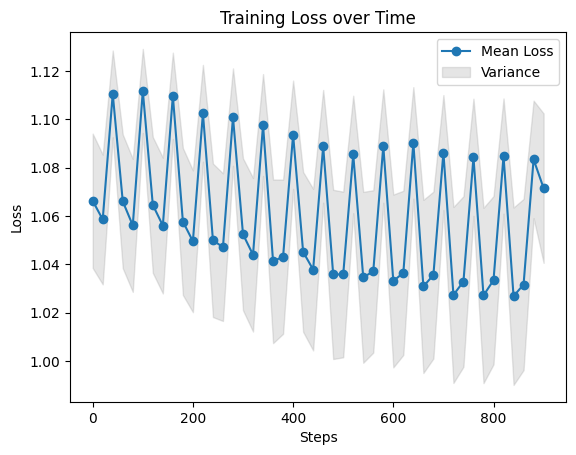

Training with  SPSA  optimizer.
Currently using subkernel size:  4  where loss is averaged over  4  loss.
Sub-kernels prepared according to Balanced: False
 Training Runtime: 7.924187450000318 secs. Results: 

QSVC Training Runtime: 0.1307422169993515 secs
--------------------------------------------------
F1 Score = 0.580
ROC AUC = 0.290
Accuracy Score = 0.612




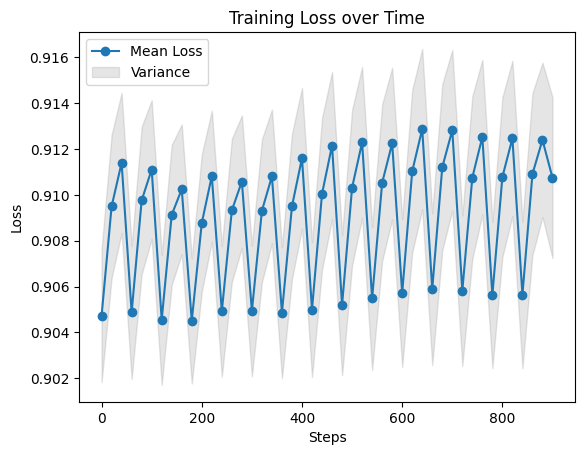

Training with  SPSA  optimizer.
Currently using subkernel size:  4  where loss is averaged over  8  loss.
Sub-kernels prepared according to Balanced: False
 Training Runtime: 15.916390317999685 secs. Results: 

QSVC Training Runtime: 0.13061486300102843 secs
--------------------------------------------------
F1 Score = 0.569
ROC AUC = 0.764
Accuracy Score = 0.571




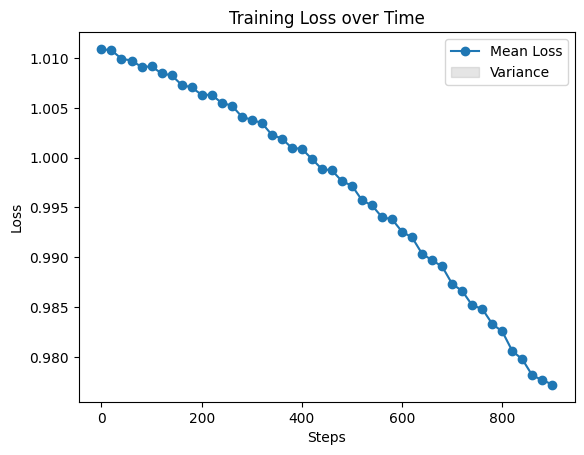

Training with  SPSA  optimizer.
Currently using subkernel size:  8  where loss is averaged over  1  loss.
Sub-kernels prepared according to Balanced: False
 Training Runtime: 3.5202397350003594 secs. Results: 

QSVC Training Runtime: 0.13276403800045955 secs
--------------------------------------------------
F1 Score = 0.674
ROC AUC = 0.769
Accuracy Score = 0.673




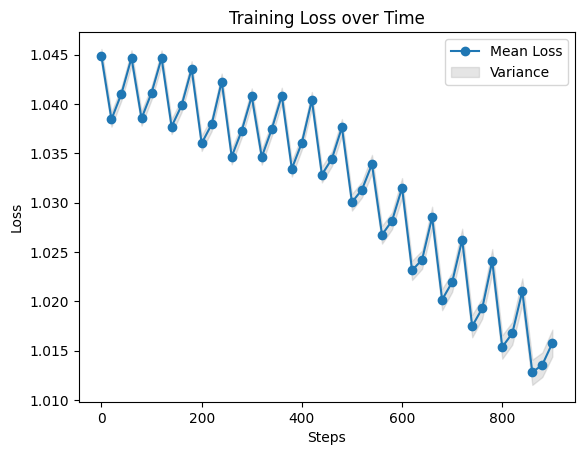

Training with  SPSA  optimizer.
Currently using subkernel size:  8  where loss is averaged over  4  loss.
Sub-kernels prepared according to Balanced: False
 Training Runtime: 14.0913119249999 secs. Results: 

QSVC Training Runtime: 0.13177208300112397 secs
--------------------------------------------------
F1 Score = 0.734
ROC AUC = 0.229
Accuracy Score = 0.735




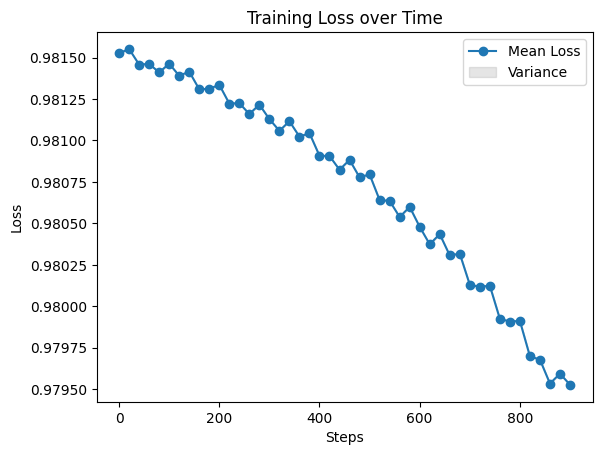

Training with  SPSA  optimizer.
Currently using subkernel size:  8  where loss is averaged over  8  loss.
Sub-kernels prepared according to Balanced: False
 Training Runtime: 21.131483471999672 secs. Results: 

QSVC Training Runtime: 0.13192985099885846 secs
--------------------------------------------------
F1 Score = 0.550
ROC AUC = 0.811
Accuracy Score = 0.551




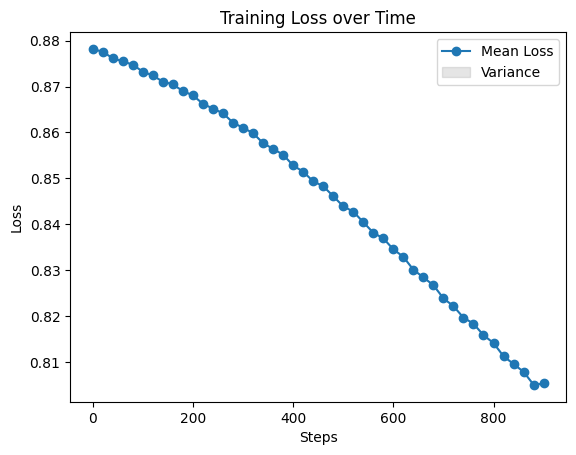

Training with  SPSA  optimizer.
Currently using subkernel size:  16  where loss is averaged over  1  loss.
Sub-kernels prepared according to Balanced: False
 Training Runtime: 7.046141578999595 secs. Results: 

QSVC Training Runtime: 0.13204624999889347 secs
--------------------------------------------------
F1 Score = 0.550
ROC AUC = 0.811
Accuracy Score = 0.551




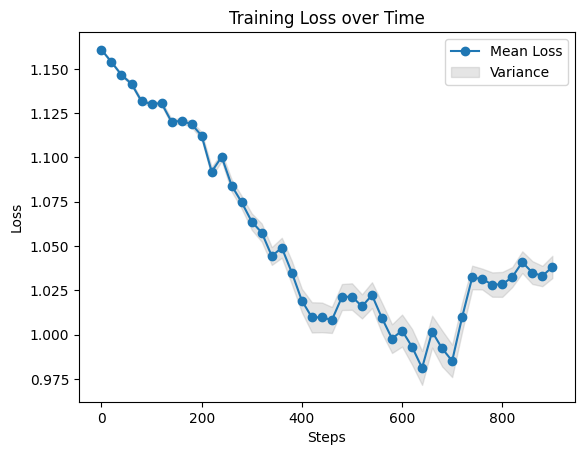

Training with  SPSA  optimizer.
Currently using subkernel size:  16  where loss is averaged over  4  loss.
Sub-kernels prepared according to Balanced: False
 Training Runtime: 21.13358799100024 secs. Results: 

QSVC Training Runtime: 0.1310164740007167 secs
--------------------------------------------------
F1 Score = 0.550
ROC AUC = 0.811
Accuracy Score = 0.551




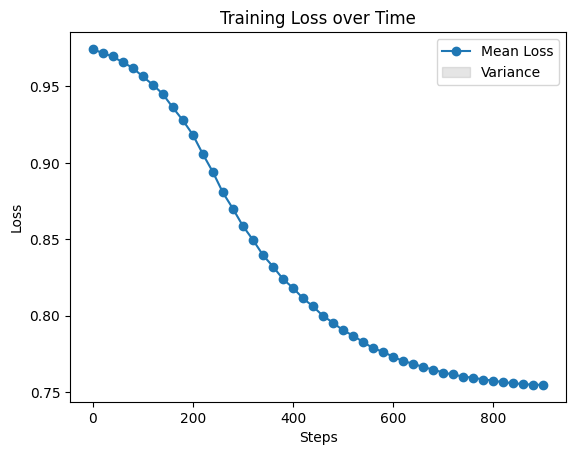

Training with  SPSA  optimizer.
Currently using subkernel size:  16  where loss is averaged over  8  loss.
Sub-kernels prepared according to Balanced: False
 Training Runtime: 20.848662290998618 secs. Results: 

QSVC Training Runtime: 0.13211113999932422 secs
--------------------------------------------------
F1 Score = 0.550
ROC AUC = 0.811
Accuracy Score = 0.551




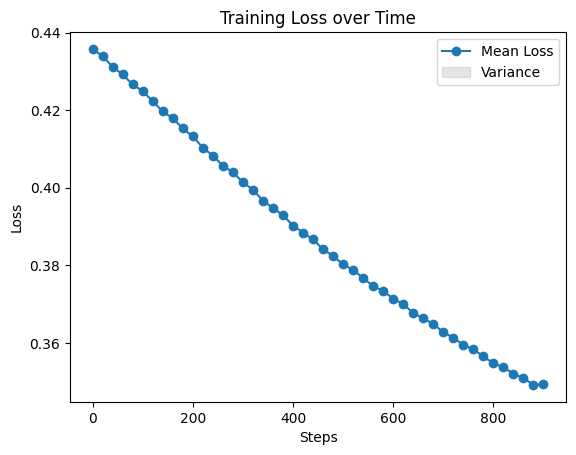

Training with  SPSA  optimizer.
Currently using subkernel size:  None  where loss is averaged over  1  loss.
Sub-kernels prepared according to Balanced: False
 Training Runtime: 28.700910376001048 secs. Results: 

QSVC Training Runtime: 0.13196324999989884 secs
--------------------------------------------------
F1 Score = 0.550
ROC AUC = 0.811
Accuracy Score = 0.551




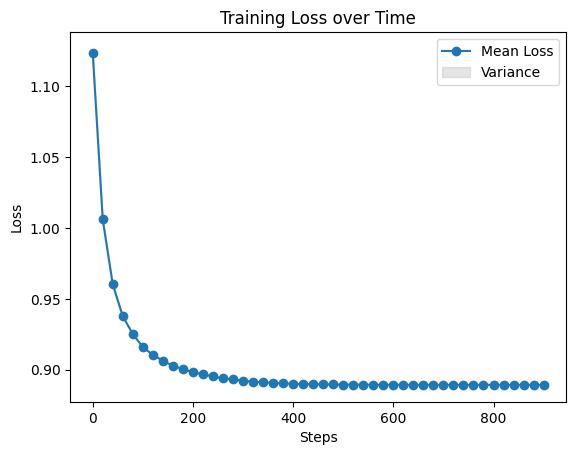

In [139]:
### Options

optimizers = ["SPSA"]
batch_sizes = [1, 4, 8]
sub_kernel_sizes = [4, 8, 16, None]
batch_types = [False]
results = {}
# init_p is the initialisation points. The closer to 0, the worst the start. 0.5 is optimial, the circuit acts as an hadamard gate.
init_p = 0.25 * np.random.uniform(-np.pi, np.pi, len(fm.training_parameters))
### End Options

for opt in optimizers:
    opt_results = []
    for sub_kernel_size in sub_kernel_sizes:
        for batch_size in batch_sizes:
            if sub_kernel_size == None:
                if batch_size != 1:
                    continue
            for batch_type in batch_types:
                if sub_kernel_size == None:
                    sk_size = len(training_data)
                    if batch_type == True:
                        continue
                else:
                    sk_size = int(sub_kernel_size)
                print("=" * 50)
                print("Training with ", opt, " optimizer.")
                print(
                    "Currently using subkernel size: ",
                    sub_kernel_size,
                    " where loss is averaged over ",
                    batch_size,
                    " loss.",
                )
                print("Sub-kernels prepared according to Balanced:", batch_type)
                print("=" * 50)
                # Get optimizer options
                cb, optimizer = get_optimizer_options(opt)
                if cb == "SPSACallback":
                    callb = QKTCallback()
                    optimizer = optimizer(callback=callb.callback)
                else:
                    optimizer = optimizer()
                # Instantiate quantum kernel
                qk = TrainableFidelityStatevectorKernel(
                    feature_map=fm, training_parameters=fm.training_parameters
                )
                # Instantiate Sub-kernel loss
                loss = BatchedSVCLoss(
                    training_data,
                    training_labels,
                    minibatch_size=batch_size,
                    sub_kernel_size=sub_kernel_size,
                    balanced_batch=batch_type,
                    shuffle=True,
                    encoder=None,
                )
                # Instantiate a quantum kernel trainer.
                qkt = QuantumKernelTrainer(
                    quantum_kernel=qk,
                    loss=loss,
                    optimizer=optimizer,
                    initial_point=init_p,
                )
                # Train the kernel
                start = timer()
                qka_results = qkt.fit(training_data, training_labels)
                end = timer()
                train_time = end - start
                print(f" Training Runtime: {train_time} secs. Results: ")
                print()
                # print('-'*80)
                # print(qka_results)
                # print('-'*80)
                # print()
                # print("Evaluating optimized kernel with the optimal parameters...")
                optimized_kernel = qka_results.quantum_kernel

                start = timer()

                # Train the QSVC using optimized quantum fidelity kernel
                qsvc, auc, f1, accuracy = run_QSVC(
                    training_data,
                    training_labels,
                    test_data,
                    test_labels,
                    optimized_kernel,
                )
                end = timer()
                qsvc_runtime = end - start
                num_support_vectors = len(qsvc.support_)

                print(f"QSVC Training Runtime: {qsvc_runtime} secs")

                # Print results
                print("-" * 50)
                print("F1 Score = %.3f" % (f1))
                print("ROC AUC = %.3f" % (auc))
                print("Accuracy Score = %.3f" % (accuracy))
                print()
                print()

                # Get the training loss
                plot_data = (
                    len(training_data) * np.array(loss.loss_arr) / (sk_size * num_support_vectors)
                )

                # Plotting
                plot_average_loss_with_variance(plot_data, N=20)

                # Append the results
                opt_results.append(
                    {
                        "ROC": auc,
                        "F1": f1,
                        "accuracy": accuracy,
                        "sub_kernel_size": sub_kernel_size,
                        "batch_size": batch_size,
                        "Balanced": batch_type,
                        "train_time": train_time,
                        "qsvc_runtime": qsvc_runtime,
                        "training_loss": plot_data.tolist(),
                        "loss": loss.loss_arr,
                        "opt_params": qka_results.optimal_point.tolist(),
                    }
                )
    results.update({opt: opt_results})

with open("Subkernel_results.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

### 4.c. Sub-Kernel Visualisation and Conclusion
By looking over the graphs produced in the experiment, we can see a trend, the larger the sub-kernel and the greater the batch size the better the model performs. This is intuitively correct, we knew that doing a QSVC using the full kernel worked very well already. The interesting thing we can note is that around the 16 size kernel mark we are already able to start replicating the performance of the full kernel training whilst drastically decreasing training time. This is showing the method working, that we can approximate for the whole dataset using these sub-kernels. 

More formally, the results show us that using the sub-kernel method for variational training of kernels leads to the construction of an "optimised" full kernel that delivers a binary classification model that is better performing (better F1 Score, AUC ROC and accuracy) compared to the use of an "un-optimised" full kernel, with lower training times than optimising the full kernel. From a Sub Kernel size of 16 upwards we can see metric results that rival the full kernel, and increasingly lowering final training loss. See results in section 2 of the paper for further conclusions [[1]](https://arxiv.org/abs/2401.02879).

Below there is a quick plotting function simply to show the training time increasing as the kernel size and batch size is increased. This is a simple way to see how the training time is decreased whilst keeping the metrics up.


['ROC', 'F1', 'Accuracy', 'Sub kernel size', 'Batch size', 'Train time (s)']
[[ 0.81144781  0.54989796  0.55102041  4.          1.          2.04759786]
 [ 0.29040404  0.58042909  0.6122449   4.          4.          7.92418745]
 [ 0.76430976  0.56892544  0.57142857  4.          8.         15.91639032]
 [ 0.76936027  0.67428844  0.67346939  8.          1.          3.52023974]
 [ 0.22895623  0.7340208   0.73469388  8.          4.         14.09131192]
 [ 0.81144781  0.54989796  0.55102041  8.          8.         21.13148347]
 [ 0.81144781  0.54989796  0.55102041 16.          1.          7.04614158]
 [ 0.81144781  0.54989796  0.55102041 16.          4.         21.13358799]
 [ 0.81144781  0.54989796  0.55102041 16.          8.         20.84866229]
 [ 0.81144781  0.54989796  0.55102041         nan  1.         28.70091038]]


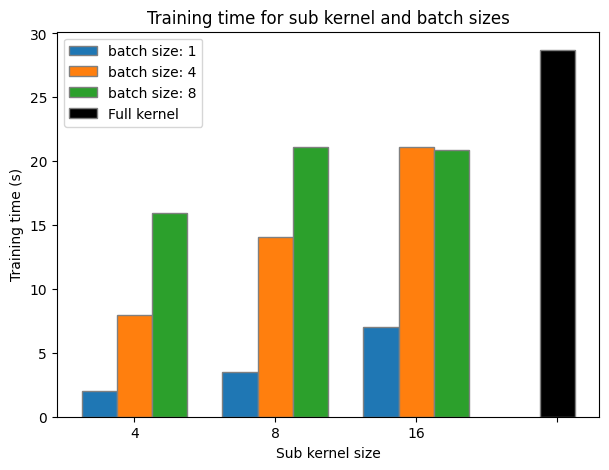

In [140]:
def plot_sub_kernel_experiments(results):
    """
    Plotting function to show a bar graph of the training time increasing with sub-kernel size and number of kernels evaluated.
    Keep in mind this fucntion is expecting the final sub kernel size to be None for comparison.
    Args:
       results (dict): plot data from the sub-kernel experiments.

    Returns:
       None

    """
    for key in results.keys():
        plot_data = results.get(key)
        selected_data = np.ones((len(plot_data), 6))
        for i in range(len(plot_data)):
            line = np.ones(6)
            line[0] = plot_data[i].get("ROC")
            line[1] = plot_data[i].get("F1")
            line[2] = plot_data[i].get("accuracy")
            line[3] = plot_data[i].get("sub_kernel_size")
            line[4] = plot_data[i].get("batch_size")
            line[5] = plot_data[i].get("train_time")
            selected_data[i] = line

        bar_chart_data = np.ones((len(batch_sizes), len(sub_kernel_sizes) - 1, 6))
        for j in range(len(batch_sizes)):
            for k in range(len(sub_kernel_sizes) - 1):
                bar_chart_data[j, k] = selected_data[len(batch_sizes) * k + j]

        fig, ax = plt.subplots(1, 1, figsize=(7, 5))
        barWidth = 0.25
        br = np.arange(len(sub_kernel_sizes) - 1)
        for l in range(len(batch_sizes)):
            label = "batch size: " + str(batch_sizes[l])
            if l > 0:
                br = [x + barWidth for x in br]
            ax.bar(br, bar_chart_data[l][:, -1], width=barWidth, edgecolor="grey", label=label)
        ax.bar(
            len(sub_kernel_sizes) - 1 + barWidth,
            selected_data[-1, -1],
            color="black",
            width=barWidth,
            edgecolor="grey",
            label="Full kernel",
        )
        ax.set_ylabel("Training time (s)")
        ax.set_xlabel("Sub kernel size")
        ax.set_xticks([r + barWidth for r in range(len(sub_kernel_sizes))], sub_kernel_sizes)
        ax.set_title("Training time for sub kernel and batch sizes")
        ax.legend()

    print(["ROC", "F1", "Accuracy", "Sub kernel size", "Batch size", "Train time (s)"])
    print(selected_data)


plot_sub_kernel_experiments(results)

## References
1. Efficient Parameter Optimisation for Quantum Kernel Alignment: A Sub-sampling Approach in Variational Training, M. Emre Sahin and Benjamin C. B. Symons and Pushpak Pati and Fayyaz Minhas and Declan Millar and Maria Gabrani and Jan Lukas Robertus and Stefano Mensa, 2024, https://arxiv.org/abs/2401.02879
2. Covariant quantum kernels for data with group structure, Glick, Jennifer R. and Gujarati, Tanvi P. and Córcoles, Antonio D. and Kim, Youngseok and Kandala, Abhinav and Gambetta, Jay M. and Temme, Kristan, 2024, https://arxiv.org/abs/2105.03406
3. Quantum Kernel Training Toolkit, Jennifer R. Glick and Tanvi P. Gujarati, 2024, https://github.com/qiskit-community/prototype-quantum-kernel-training/tree/main/data
4. Quantum Kernel Training Toolkit, Jennifer R. Glick and Tanvi P. Gujarati, 2024, https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/docs/background/qkernels_and_data_w_group_structure.ipynb
5. Quantum Kernel Training Toolkit, Jennifer R. Glick and Tanvi P. Gujarati, 2024, https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/docs/how_tos/create_custom_quantum_feature_map.ipynb
6. Quantum Kernel Training Toolkit, Jennifer R. Glick and Tanvi P. Gujarati, 2024, https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/docs/how_tos/train_kernels_using_qiskit_feature_maps.ipynb
7. The IBM Quantum heavy hex lattice, Paul Nation, Hanhee Paik, Andrew Cross, Zaira Nazario, 2021, https://www.ibm.com/quantum/blog/heavy-hex-lattice
8. Quantum Kernel Training Toolkit, Jennifer R. Glick and Tanvi P. Gujarati, 2024, https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/docs/background/svm_weighted_kernel_alignment.ipynb
9. Qiskit Algorithms 0.3.0, 2024, https://qiskit-community.github.io/qiskit-algorithms/apidocs/qiskit_algorithms.optimizers.html
10. Sequential minimal optimization for quantum-classical hybrid algorithms, Nakanishi, Ken M. and Fujii, Keisuke and Todo, Synge, 2020, https://arxiv.org/abs/1903.12166

In [6]:
import numpy as np
x1 = np.array([0.1, 0.2])
x1 = np.tile(x1, 6 // len(x1) + 1)[:6]
x1

array([0.1, 0.2, 0.1, 0.2, 0.1, 0.2])